# Chapter11. 심층 신경망 훈련

# 3. Optimizer


## Batch GD
- train set 전체로 학습을 진행하는 방식

## SGD
- 기존 gradient descent와 학습방법을 동일하지만, **full-batch가 아닌 mini batch**로 학습을 진행하는 것
- GD에 비해 빠른 수행속도와 적은 메모리 사용의 장점
- saddel point 혹은 local minimum으로 빠지는 것을 방지할 수 있음

In [2]:
import numpy as np

class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr*grads[key]

### SGD의 문제점
1. gradient가 그때그때의 mini-batch로 계산되기 때문에 꼬불꼬불하게 **비효율적으로 학습이 진행됨**
2. saddle point 혹은 local minimum에 빠지는 문제가 생길 수 있음

## Momentum

- SGD에 momentum 개념을 추가한 것
- 현재의 mini-batch로만 학습하는 것이 아니라 이전의 mini-batch의 학습결과도 반영
- actual gradient = velocity + gradient
- 파라미터 momentum의 크기에 따라 학습이 달라짐
	- momentum의 크기가 커지면 더 많은 gradient를 반영

### 모멘텀 알고리즘
- $V$ : 모멘텀 벡터(momentum vector)
- $\beta$ : 모멘텀(momentum), 0~1 사이(보통 0.9)
    - 모멘텀 벡터에 대한 저항을 주는 역할

#### 방법1
1. $V_{0} = \vec{0}$
2. $V_{t} = \beta V_{t-1}+(1-\beta) dW_{t}$
3. $W_{t+1} = W_{t} -\lambda V_{t}$

#### 방법2
1. $V_{0} = \vec{0}$
2. $V_{t} = \beta V_{t-1}-\lambda dW_{t}$
3. $W_{t+1} = W_{t} + V_{t}$

*방법1과 방법2의 차이*
- 만약, $V_{t-1}과 V_{t}$가 같다면, 즉 평평한 지역에 있다면,
    - 방법 1 : $W_{t+1} <= W_{t} - \lambda dW_{t}$
    - 방법 2 : $W_{t+1} <= W_{t} - \frac{\lambda}{1-\beta}dW_{t}$  
- 방법 1은 학습률을 곱한 gradient(=GD)로, 방법 2는 학습률을 곱한 gradient에 $\frac{1}{1-\beta}$을 곱한 것과 같기 때문에 만약 $\beta$가 0.9라면 10배더 빠르게 진행됨. 이는 더 빠르게 평평한 지역을 탈출하게 도와줌($V_{t-1}과 V_{t}$가 같다는 뜻이 평평한 지역에 있다는 의미이기 때문). 이 때문에 건너뛰었다가 다시 돌아오고 하는 식의 훈련이 이루어질 수 있는데, 이는 momentum을 조정해줌으로써 해결가능

In [15]:
# 방법 1의 알고리즘
class Momentum:
    def __init__(self, lr=0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        # 초기화
        if self.v is None:
            self.v = []
            for param in params:
                self.v.append(np.zeros_like(param))  
                
        # 파라미터 업데이트
        for i in range(len(params)):
            self.v[i] = self.momentum*self.v[i]+(1-self.momentum)*grads[i]
            params[i] -= self.lr*self.v[i]

In [1]:
# 방법 2의 알고리즘
class Momentum:
    def __init__(self, lr=0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = []
            for param in params:
                self.v.append(np.zeros_like(param))
        
        for i in range(len(params)):
            self.v[i] = self.momentum*self.v[i]-self.lr*grads[i]
            params[i] += self.v[i]

- saddle point와 local minimum에 빠지는 것을 방지할 수 있음
- 학습이 효율적으로 이루어짐
    - SGD의 경우 지그재그로 학습이 이루어지는데, 이를 막을 수 있음
    - 일반적인 gradient descent의 경우 입력값의 스케일이 매우 다르면 비용 함수가 한쪽이 길쭉한 그릇처럼 됨. 이 때 가파른 경사를 꽤 빠르게 내려가지만 좁고 긴 골짜기에서는 오랜 시간이 걸림. momentum optimizer는 골짜기를 따라 바닥에 도달할 때까지 점점 빠르게 내려가도록 도와줌

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum = 0.9)

## 네스테로프 가속 경사(Nesterov accelerated gradient)

- Momentum optimizer의 변종으로 기본 Momentum optimizer보다 거의 항상 더 빠름
- 진동을 감소시키고 수렴을 빠르게 하는 효과도 있을 수 있음
- 현재 위치에서 $dW$를 계산하는 것이 아닌 모멘텀의 방향으로 조금 앞선 $W+\beta V$에서 비용함수의 $dW$를 계산
    - 일반적으로 momentum 벡터가 올바른 방향을 가리키기 때문

### 네스테로프 가속 경사 알고리즘(momentum 방법2를 사용)
1. $V_{0} = \vec{0}$
2. $W_{t'} = W_{t} + \beta V_{t-1}$
2. $V_{t} <= \beta V_{t-1}-\lambda dW_{t'}$
3. $W_{t+1} <= W_{t} + V_{t}$

In [ ]:
# 네스테로프 인자를 True로 만들어주면 됨
optimizer = keras.optimizers.SGD(lr = 0.001, momentum = 0.9, nesterov = True)

*번외*  
실제 코드로 구현되어 있는 네스테로프 가속 경사 알고리즘은 모멘텀을 두번 적용한 것과 같음
1. $V_{0} = \vec{0}$
2. $V_{temp} = \beta V_{t-1}-\lambda dW_{t}$
3. $V_{t} = \beta V_{temp}-\lambda dW_{t}$
4. $W_{t+1} = W_{t} + V_{t}$

## AdaGrad
- 많이 학습된 가중치에 대해서는 학습률을 감소시키고(minimum에 가까워졌을 것이기 때문), 덜 학습된 가중치에 대해서는 학습률을 덜 증가시키면서 학습(차원별로 학습률이 다르게 감소)
    - 학습률을 감소시키지만 경사가 완만한 차원보다 가파른 차원에 대해 더 빠르게 감소
    - 적응적 학습률(adaptive learning rate)
- gradient의 원소별 제곱을 그레디언트 제곱 벡터에 누적하고, 그레디언트 벡터를 원소별로 $\sqrt{S+\epsilon}$으로 나누어줌으로써 학습 스케일을 조정
- 학습률($\lambda$)를 덜 튜닝해도 되는 이점이 있음

### Adagrad 알고리즘
- $S$ : gradient 제곱 누적벡터
- $\epsilon$ : 0으로 나누는 것을 막기 위한 값(일반적으로 $10^{-10}$

1. $S_{0} = \vec{0}$
3. $S_{t} = S_{t-1}+ (dW_{t})^{2}(원소별)$
4. $W_{t+1} = W_{t} - \frac{\lambda}{\sqrt{S_{t}+ \epsilon}} dW_{t}(원소별 나눗셈)$

#### Adagrad의 문제점
- 학습률이 너무 감소되어 전역 최적점에 도착하기 전에 알고리즘이 완전히 멈추는 문제
- 선형회귀같은 간단한 작업에는 효과적일 수 있지만, 심층 신경망에는 사용하지 않는 것이 좋음

## RMSProp
- Adagrad에서 지수이동평균을 사용하여 gradient의 최신성에 따라 반영률을 다르게 해줌으로써 Adagrad의 문제를 해결

### RMSProp 알고리즘
- $S$ : gradient 제곱 누적벡터
- $\epsilon$ : 0으로 나누는 것을 막기 위한 값(일반적으로 $10^{-10}$
- $\beta$ : 감쇠율(보통 0.9로 설정)

1. $S_{0} = \vec{0}$
2. $S_{t} = \beta S_{t-1}+(1-\beta) (dW_{t})^{2}$
3. $W_{t+1} = W_{t} -\frac{\lambda}{\sqrt{S_{t}+ \epsilon}} dW_{t}$

In [ ]:
# default -> learnging rate : 0.001, rho : 0.9
optimizer = keras.optimizers.RMSprop(lr = 0.001, rho = 0.9)

## Adam(Adaptive momentum estimation)
- 적응적 모멘트 추정 -> 하이퍼파라미터를 튜닝할 필요가 적음(보통 0.001사용)
- momentum과 RMSProp의 아이디어를 합친 것
- 지난 그레디언트의 지수이동평균을 따르고 RMSProp처럼 지난 그레디언트 제곱의 지수이동평균을 따름

### Adam 알고리즘
- $\beta_{1}$ : momentum 하이퍼파라미터(보통 0.9)
- $\beta_{2}$ : RMSProp 하이퍼 파라미터(보통 0.99)
- $\epsilon$ : 안정된 계산을 위한 term($10^{-7}$)

1. $V_{0} = \vec{0}$, $S_{0} = \vec{0}$
2. $V_{t} = \beta V_{t-1}+(1-\beta) dW_{t}$
4. $S_{t} = \beta S_{t-1}+(1-\beta) (dW_{t})^{2}$
3. $V_{t}^{biascorr} = \frac{V_{t}}{1-\beta_{1}^{t}}$
3. $S_{t}^{biascorr} = \frac{S_{t}}{1-\beta_{2}^{t}}$
5. $W_{t+1} = W_{t} -\frac{\lambda}{\sqrt{S_{t}^{biascorr}+ \epsilon}} V_{t}^{biascorr}$

- momentum과 RMSProp은 지수이동평균을 사용하기 때문에 훈련 초기에 값이 0쪽으로 치우치게 되는 문제가 발생. 따라서 해당 단계를 통해서 초기 $V, S$의 값을 증폭시키는데 도움을 줌

In [ ]:
keras.backend.set_epsilon() # epsilon의 값을 바꾸는 방법
optimizer = keras. optimizers.Adam(lr=0.001, beta_1 = 0.9, beta_2 = 0.999)

## AdaMax
- Adam이 $l_{2}$ 노름으로 파라미터 업데이트 스케일을 낮춘다면, AdaMax는 $l_{\inf}$ 노름으로 파라미터 업데이트 스케일을 낮춤.
- Adam의 단계3이 $S_{t} = max(\beta_{2}S_{t-1}, dW_{t}))$으로 수정됨
- 시간에 따라 감소된 그레디언트의 최댓값. 
- AdaMax가 Adam보다 더 안정적이지만, 실제로 데이터셋에 따라 다르고 일반적으로 Adam의 성능이 더 나음

## Nadam
- Adam optimizer에 Nadam optimizer를 더한 것
- 종종 Adam보다 빠르게 수렴
- 일반적으로 Nadam이 Adam보다 성능이 좋았지만 이따금 RMSProp이 나을 때도 있음

## 2차 편미분(헤시안)기반 알고리즘
- 여태까지의 모든 최적화 기법은 **1차 편미분(야코비안)** 에만 의존
- **2차 편미분(헤시안)** 을 기반으로 한 뛰어난 알고리즘들도 많음. 하지만 심층 신경망에 이를 적용하면 n개의 1차 편미분에서 $n^{2}$의 2차 편미분을 계산해야 하기 때문에, 메모리 용량을 넘어서는 경우가 많고 가능하다 해도 너무 느린 문제가 있음

## 희소 모델 훈련
- 모든 최적화 알고리즘은 대부분의 파라미터가 0이 아닌 밀집(dense) 모델을 생성.
- 만약, 희소(sparse) 모델이라면 메모리를 적게 차지하고 엄청 빠르게 실행됨.
### 희소행렬 생성 방식
1. 모델을 훈련하고 작은 값의 가중치를 제거. -> 많이 희소한 모델을 만들지 못하고 모델의 성능이 낮아짐 
2. $l_{1}$ 규제를 강하게 적용. optimizer가 가능한 한 많은 가중치를 0으로 만들도록 강제
- 텐서플로 모델 최적화 툴킷(TF-MOT)에서 훈련하는 동안 반복적으로 연결 가중치를 크기에 맞춰 제거하는 가지치기 API 사용

## Optimizer 비교
- RMSProp, Adam, Nadam 등의 최적화를 포함한 적응적 최적화 방법이 좋은 솔루션으로 **빠르게** 수렴
- 하지만 만약, 일부 데이터셋에서 나쁜 결과가 나오기 때문에 모델의 성능이 만족스럽지 못하면 기본 네스테로프 가속 경사를 사용하는 것도 좋음


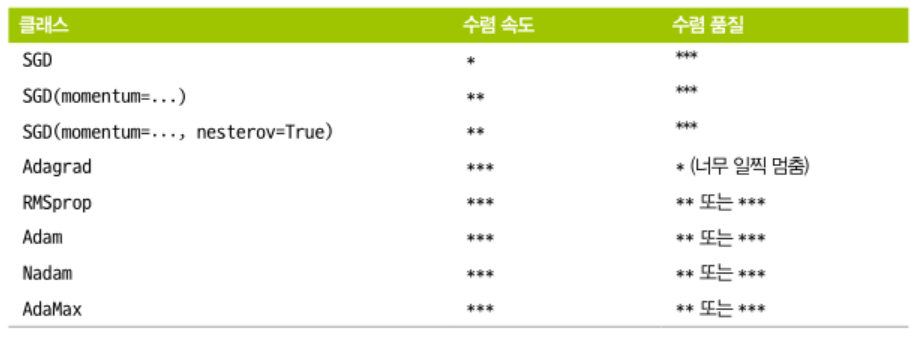